In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [75]:
import channelparams
from shooting import *
from theory import *
from utils import *

In [76]:
fbc = channelparams.fbc.copy()
r = fbc['rsill']

In [77]:
def shoot_2d(α, r, nx=50, nβ=100, nγ=100):
    βs = np.logspace(-0.75, np.log10(3), num=nβ) #np.linspace(1e-3, 1., nβ)
    γs = np.logspace(-1.5, np.log10(3**2), num=nγ) #np.linspace(1e-3, 1., nγ)
    
    match = np.zeros((nγ, nβ))
    Q = np.zeros((nγ, nβ))
    for jj, β in enumerate(βs):
        for kk, γ in enumerate(γs):
            outputs = shoot_perturbations(α, β, γ, r, nx)
            match[kk,jj] = outputs['match']
            Q[kk,jj] = outputs['Q']
            
            
    outputs = {
        "βs": βs,
        "γs": γs,
        "match": match,
        "Q": Q,
    }
    return outputs

In [78]:
def plot_interface(ax, α, β, γ, r, nx = 200):
    xL = (-β+np.sqrt(β**2 - 4*α*γ))/(2*α)
    xR = (-β-np.sqrt(β**2 - 4*α*γ))/(2*α)
    w = xR-xL

    xm = np.maximum(np.abs(xL), np.abs(xR)) + w/10
    dx = 2*xm/nx

    x = np.arange(-xm, xm+dx, dx)

    h = x**2/r
    d = α*x**2 + β*x + γ
    η = d+h
    η[d<0.] = np.nan
    d[d<0.] = np.nan

    z = np.linspace(0., np.nanmax(η), 100)[np.newaxis, :]
    v = (2.*(α + 1/r)*x + β)[:, np.newaxis]

    xx = np.tile(x[:, np.newaxis], (1, z.size))
    zz = np.tile(z, (x.size, 1))
    vv = np.tile(v, (1, z.size))
    vv[np.logical_not(np.logical_and(zz > h[:, np.newaxis], zz < η[:, np.newaxis]))] = np.nan
    ax.pcolor(xx, zz, vv, cmap="RdBu_r", vmin=-np.nanmax(np.abs(v)), vmax=np.nanmax(np.abs(v)))

    ax.plot(x, h, color="Grey", lw=2)
    ax.plot(x, η, "k-", lw=2)

    ax.set_ylim(-np.max(h)/30, np.max(h))
    return

### Load ZPV channel simulation

In [86]:
path = "../hydraulic_model/runs/zero_pv_ic/"
filename = path+"run_short.dat"
channel = load_channel(filename)

In [87]:
α_zpv = -0.5*(1.+2./r)

### Fit parameters to interface

In [41]:
vpv_fits = {
    "α": np.zeros((channel.my)),
    "β": np.zeros((channel.my)),
    "γ": np.zeros((channel.my))
}

zpv_fits = {
    "β": np.zeros((channel.my)),
    "γ": np.zeros((channel.my))
}

In [89]:
t = -1
for i in range(channel.my):
    idx = ~np.isnan(channel.d[t,:,i])
    vpv_fits["α"][i], vpv_fits["β"][i], vpv_fits["γ"][i] = np.polyfit(channel.x[0,:][idx], channel.d[t,:,i][idx], 2)
    zpv_fits["β"][i], zpv_fits["γ"][i] = np.polyfit(
        channel.x[0,:][idx],
        channel.d[t,:,i][idx] - α_zpv*(channel.x[0,:][idx]**2),
        1
    )

(-1.2, 1.2)

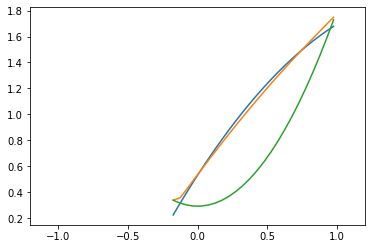

In [101]:
i = 1200
idx = ~np.isnan(channel.d[t,:,i])
x = channel.x[0,:][idx]

plt.plot(x, α_zpv*x**2 + x*zpv_fits["β"][i] + zpv_fits["γ"][i]+channel.h[:,i][idx])
plt.plot(channel.x[0,:], channel.d[t,:,i]+channel.h[:,i])
plt.plot(channel.x[0,:][idx], channel.h[:,i][idx])
plt.xlim(-1.2,1.2)

(0.2, 2.0)

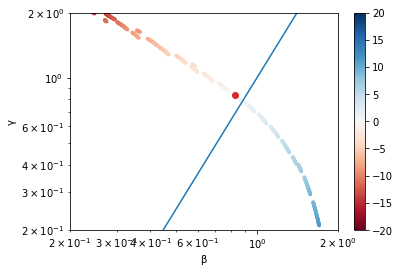

In [130]:
plt.scatter(zpv_fits["β"], zpv_fits["γ"], 30., channel.y[:, 0]-channel.y[channel.my//2, 0], marker=".", cmap="RdBu", vmin=-20, vmax=20)
plt.colorbar()
plt.plot(zpv_fits["β"][1000], zpv_fits["γ"][1000], "C3o")
plt.xlabel("β")
plt.ylabel("γ")
plt.xscale("log")
plt.yscale("log")
βs = np.arange(0., 2., 0.01)
plt.plot(βs, γ_zpv(βs, r))
plt.ylim(0.2, 2)
plt.xlim(0.2, 2.)

In [48]:
np.polyfit(channel.y[0,:], channel.d[i,:], 2)

IndexError: index 1999 is out of bounds for axis 0 with size 500

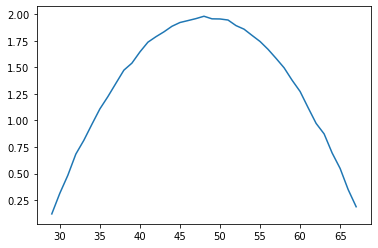

In [24]:
plt.plot(channel.d[t,:,100])